### 製作word2vec模型

In [21]:
import jieba
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import time
from functools import reduce
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib as mpl
from multiprocessing import Pool
import os

In [2]:
df_jiebatop40=pd.read_json('jieba_top40_1.json',lines=True)
df_jiebatop40['jieba_list']=df_jiebatop40.jieba_cut.apply(lambda x:x.split(','))
jiebatop40_list=df_jiebatop40.jieba_list.tolist()

In [3]:
model = Word2Vec(jiebatop40_list, vector_size=100,min_count=1,workers=4, window =3, sg = 1)

In [4]:
def similar(A,B):
    w2v_similarity=[]
    vec_A_book = np.zeros(100)
    for v in A:
        vec_A_book += model.wv[v]
    for v in B:
        vec_B_book = np.zeros(100)
        for s in v:
            vec_B_book += model.wv[s]
        w2v_similarity.append(np.dot(vec_A_book, vec_B_book) / (np.linalg.norm(vec_A_book)*np.linalg.norm(vec_B_book)))
    return w2v_similarity

In [7]:
book_1=jiebatop40_list[0]
similarity_10_booklist=jiebatop40_list[:10]
similarity=similar(A=book_1,B=similarity_10_booklist)
print("第一本與前十本書的相似度: ", [round(i,3) for i in similarity[:10]])

第一本與前十本書的相似度:  [1.0, 0.952, 0.943, 0.926, 0.932, 0.939, 0.945, 0.959, 0.933, 0.946]


### 模型評估:第10萬本書與前五名最相似的書

In [12]:
start_time=time.time()
book_1=jiebatop40_list[100000]
similarity_all_booklist=jiebatop40_list[:len(df_jiebatop40)]
similarity=similar(A=book_1,B=similarity_all_booklist)

topK=5
arr_similarity=np.array(similarity)
top_5_index=arr_similarity.argsort()[::-1][0:topK+1]
end_time=time.time()
print('第10萬本書最相似的前五名書籍',top_5_index[1:])
print('一本書需消耗',round(end_time-start_time),'秒鐘')

第10萬本書最相似的前五名書籍 [100126 100137  99057 113126  99052]
一本書需消耗 32 秒鐘


In [13]:
# 書籍名稱與isbn
df_jiebatop40.iloc[top_5_index,:2]

,書名,ISBN
100000,圖學升學寶典2012年（土木與建築群）升科大四技,9789862389263
100126,圖學升學寶典2011年版(土木與建築群),9789862384633
100137,圖學升學寶典2010年版(土木與建築群),9789862381724
99057,機械力學升學寶典2012年版(機械群)升科大四技,9789862388563
113126,機械力學模擬測驗試題詳解(機械群)升科,9789861298962
99052,機件原理跨越講義2012年版(機械群)升科大四技(附解析本),9789862388679


In [14]:
#儲存 model
model.save("word2vec_book_words.model")

### 製作向量:TSNE, 多CPU前處理

In [15]:
def books_to_model(Books):
    books_arr=[]
    for book_keywords in Books:
        vec_book = np.zeros(100)
        for keyword in book_keywords:
            vec_book += model.wv[keyword]
        books_arr.append(vec_book)
    return books_arr
books_arr=books_to_model(Books=jiebatop40_list)

In [16]:
np.save('all_books_vector', books_arr)

### 模型評估:前一萬本書 - 資料降維 T-SNE

In [17]:
all_books_vector = np.load('all_books_vector.npy')

In [18]:
tsne = TSNE(n_components=2,random_state=1818)
Y = tsne.fit_transform(all_books_vector[:10000])
x_coords = Y[:10000, 0]
y_coords = Y[:10000, 1]

C:\Users\Tibame_T14\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tibame_T14\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


書本與書本之間的距離，散點分布狀態如下:


<IPython.core.display.Javascript object>


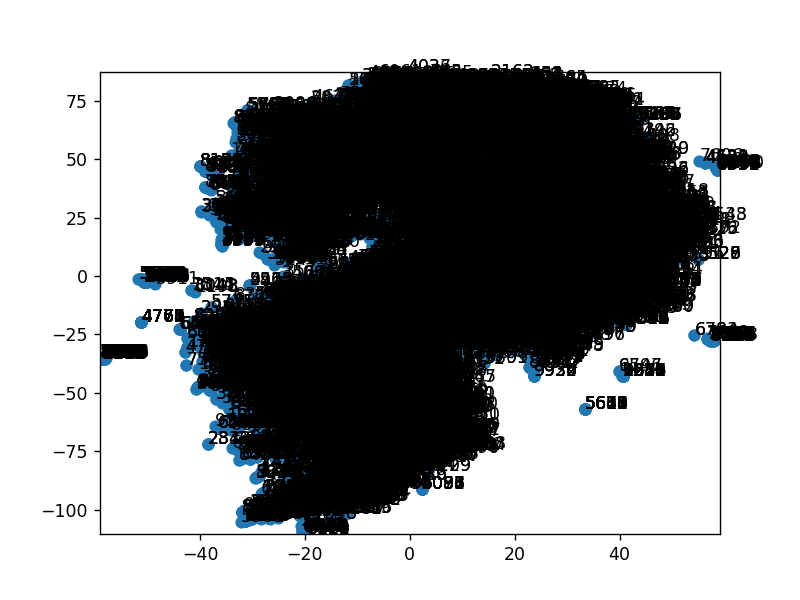

In [19]:
print('書本與書本之間的距離，散點分布狀態如下:')
plt.scatter(x_coords, y_coords)
labels=[i for i in range(10000)]
for label, x, y in zip(labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points') # offset points
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()


### 對每一本書找出最相似的五本書(py檔才能用到多CPU)

In [ ]:
def similar(A):
    global all_books_vector
    if all_books_vector is None:
        all_books_vector=all_books_vector
    similarities=map(lambda x:(np.dot(A,x) / (np.linalg.norm(A)*np.linalg.norm(x))),all_books_vector)
    similarities=np.array(list(similarities))
    
    topK=5
    top_5_index=similarities.argsort()[::-1][1:topK+1]
    
    return top_5_index.tolist()

if __name__ == '__main__':
    start_num=0
    end_num=100
    
    with Pool(4) as p:
        s=p.map(similar,all_books_vector[start_num:end_num]) # 做上方function
        
    books_dict={}
    for i in range(start_num,end_num): # 
        books_dict[str(i)]=s[i-start_num] 
        
    # 存成json檔
    with open('book_%s.json'%(end_num),'w') as f: 
        f.write(json.dumps(books_dict)) 

### 合併全部的DataFrame, Data cleaning

In [22]:
filelist=os.listdir('all_top5_book./')
filelist.sort(key=lambda x:int(x[5:-5]))

In [23]:
df_parts=map(lambda x:pd.read_json(f'./all_top5_book/{x}'),filelist)
sims_df=reduce(lambda x, y:pd.concat([x,y],axis=1), df_parts)
sims_df=sims_df.T
print('before drop duplicated data, sims_df rows:',len(sims_df))

sims_df.reset_index(inplace=True)
sims_df=sims_df.drop_duplicates(subset='index',ignore_index=True)
print('after drop duplicated data, sims_df rows:',len(sims_df))

before drop duplicated data, sims_df rows: 482833
after drop duplicated data, sims_df rows: 472833


In [24]:
df=pd.concat([df_jiebatop40,sims_df],axis=1)
for i in range(0,5): # 轉型別
    df[i]=df[i].astype('int')
for i in range(5):  # 轉換ISBN
    df[i]=df[i].apply(lambda x :df_jiebatop40.iloc[x,1])

In [25]:
df['top5_list']=df[0]+','+df[1]+','+df[2]+','+df[3]+','+df[4]
df['top5_list']=df['top5_list'].apply(lambda x:x.split(','))

In [26]:
save_df=df[['ISBN','top5_list']]
save_df

,ISBN,top5_list
0,9789869590235,"[9789576074585, 9789860734607, 9789869812887, ..."
1,9789863844433,"[9789865200275, 9789862483176, 9789869141109, ..."
2,9789864779376,"[9789866841637, 9789578795068, 9789867470317, ..."
3,9789570856712,"[9789862717301, 4717702087517, 9789865519155, ..."
4,9789869278799,"[9789861441917, 9789576554155, 9789571157306, ..."
...,...,...
472828,9789571311630,"[9789571315416, 9789571315812, 9789571310824, ..."
472829,9789571322995,"[9789571322995, 9789571322537, 9789571307350, ..."
472830,9789571309859,"[9789571309699, 9789571308319, 9789571308401, ..."
472831,9789571307664,"[9789861780962, 9789576184062, 9789576184031, ..."


In [ ]:
# 存成json
save_df.to_json('book_recommendation.json',orient='records',force_ascii=False,lines=True)